In [1]:
from pymongo import MongoClient
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import joblib
import datetime
from dotenv import load_dotenv
import os

In [2]:
load_dotenv(dotenv_path='../.env')

True

In [3]:
client = MongoClient(os.environ['MONGO_CONNECTION_STRING'])
db = client[os.environ['DB_NAME']]
collection = db[os.environ['COLLECTION_NAME']]

In [4]:
# Fetch data from MongoDB
data = pd.DataFrame(list(collection.find()))

In [5]:
# Extract 'citations' and 'published' fields
def get_citations(x):
    if isinstance(x, dict) and '$numberInt' in x:
        return int(x['$numberInt'])
    elif isinstance(x, (int, float)) and not pd.isnull(x):
        return int(x)
    else:
        return None  # or any other value you want to use for 'unknown'

data['citations'] = data['citations'].apply(get_citations)

data['published'] = pd.to_datetime(data['published'])

import pytz
earliest_date = datetime.datetime(1900, 1, 1, tzinfo=pytz.UTC)
data['published'] = (data['published'] - earliest_date).dt.days

In [6]:
# Normalize data
scaler = MinMaxScaler()
data[['n_citations', 'n_published']] = scaler.fit_transform(data[['citations', 'published']])

In [7]:
data.isna().sum()

_id                    0
id                     0
title                  0
authors                0
published              0
summary                0
keywords               0
doi                    0
citations              1
label               1849
n_citations            1
n_published            0
silhouette_score    1849
text_label          1849
dtype: int64

In [8]:
data = data.dropna(subset=['citations'])

In [9]:
# Define your weight factor
weight_factor = 5

# Scale the 'citations' column
data['n_citations'] = data['n_citations'] * weight_factor

In [10]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(data[['n_citations', 'n_published']])

# Add a 'label' column with the cluster labels
data['label'] = kmeans.labels_

/Users/devarajag/Projects/OpenResearchAI/DataCollector/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [11]:
# Save model for future use
joblib.dump(kmeans, 'sem-vs-sta_model.pkl')

['sem-vs-sta_model.pkl']

In [12]:
# Take a random sample from the data
sample = data.sample(n=10)

# Normalize the sample
sample[['n_citations', 'n_published']] = scaler.transform(sample[['citations', 'published']])

# Predict the cluster labels of the sample
labels = kmeans.predict(sample[['n_citations', 'n_published']])

# Print the sample data and their predicted labels
for i in range(len(sample)):
    print(f"Date: {sample.iloc[i]['published']}")
    print(f"Citations: {sample.iloc[i]['citations']}")
    print(f"Predicted label: {labels[i]}")

Date: 39963
Citations: 3.0
Predicted label: 0
Date: 39928
Citations: 1.0
Predicted label: 0
Date: 40047
Citations: 7.0
Predicted label: 0
Date: 39885
Citations: 2.0
Predicted label: 0
Date: 39945
Citations: 3.0
Predicted label: 0
Date: 39974
Citations: 7.0
Predicted label: 0
Date: 39837
Citations: 2.0
Predicted label: 0
Date: 39880
Citations: 6.0
Predicted label: 0
Date: 39950
Citations: 3.0
Predicted label: 0
Date: 39820
Citations: 24.0
Predicted label: 0


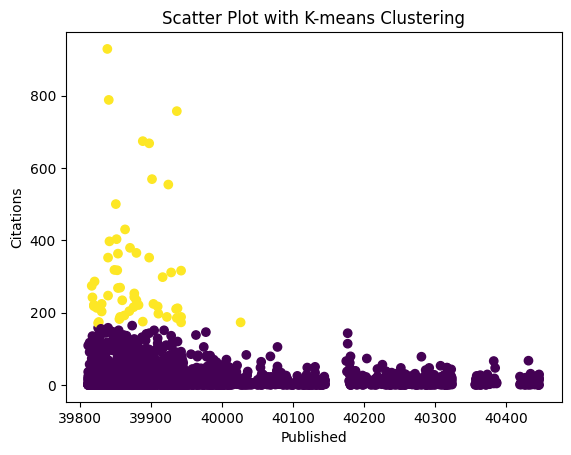

In [13]:
import matplotlib.pyplot as plt

# Plot the data with different colors for each cluster
plt.scatter(data['published'], data['citations'], c=data['label'])

plt.xlabel('Published')
plt.ylabel('Citations')
plt.title('Scatter Plot with K-means Clustering')
plt.show()

In [14]:
from sklearn.metrics import silhouette_samples

def compute_silhouette_scores(data, features, labels):
    # Compute silhouette scores for each sample
    scores = silhouette_samples(data[features], data[labels])

    # Add silhouette scores as a new column in the DataFrame
    data['silhouette_score'] = scores

# Call the function with 'n_citations' and 'n_published' as features and 'label' as labels
compute_silhouette_scores(data, ['n_citations', 'n_published'], 'label')

In [15]:
data[['authors', 'citations','published','label','title','silhouette_score']]

,authors,citations,published,label,title,silhouette_score
0,"[G. Á. Bakos, G. Torres, A. Pál, J. Hartman, G...",117.0,39813,0,HAT-P-11b: A Super-Neptune Planet Transiting a...,0.444231
1,[Sebastien Charnoz],3.0,39816,0,Physical collisions of moonlets and clumps wit...,0.846928
2,"[Sarah E. Dodson-Robinson, Peter Bodenheimer]",6.0,39817,0,Discovering the Growth Histories of Exoplanets...,0.848721
3,"[M. Vanko, St. Raetz, M. Mugrauer, T. O. B. Sc...",2.0,39817,0,Transit observations at the observatory in Gro...,0.847030
4,"[Phil Arras, Aristotle Socrates]",9.0,39818,0,Thermal Tides in Short Period Exoplanets,0.849543
...,...,...,...,...,...,...
3105,[David G. Turner],1.0,40010,0,Polaris and its Kin,0.847654
3106,"[Paola Marigo, Bernhard Aringer]",49.0,40010,0,Low-temperature gas opacity - AESOPUS: a versa...,0.787295
3107,"[Masahiro N. Machida, Shu-ichiro Inutsuka, Tom...",14.0,40011,0,First Direct Simulation of Brown Dwarf Formati...,0.847565
3108,"[Masahiro N. Machida, Shu-ichiro Inutsuka, Tom...",6.0,40011,0,The Circumbinary Outflow: A Protostellar Outfl...,0.849014


In [16]:
data['label'].describe()

count    3109.000000
mean        0.017691
std         0.131845
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: label, dtype: float64

In [17]:
data['silhouette_score'].describe()

count    3109.000000
mean        0.806787
std         0.115520
min         0.005092
25%         0.799739
50%         0.854569
75%         0.869876
max         0.878764
Name: silhouette_score, dtype: float64

In [18]:
def label_text(row):
    if row['label'] == 0 and row['silhouette_score'] > 0.85:
        return 'STA'
    elif row['label'] == 1:
        return 'SEMINAL'
    else:
        return 'NEUTRAL'

data['text_label'] = data.apply(label_text, axis=1)

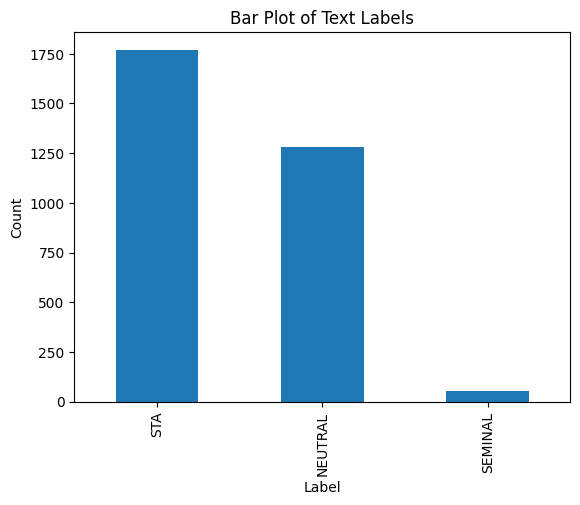

In [19]:
# Get the count of each label
label_counts = data['text_label'].value_counts()

# Create a bar plot of the label counts
label_counts.plot(kind='bar')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Bar Plot of Text Labels')
plt.show()

In [20]:
# Iterate over DataFrame rows
for index, row in data.iterrows():
    # Create a new document with the updated fields
    new_values = { "$set": { "n_citations": row['n_citations'], "n_published": row['n_published'], "label": row['label'], "silhouette_score": row['silhouette_score'], "text_label": row['text_label'] } }
    
    # Update the document in the collection
    collection.update_one({"_id": row['_id']}, new_values)